<a href="https://colab.research.google.com/github/BergmannJustin/Image_Classification_Pr-fung/blob/main/Image_Classification_Project_Pr%C3%BCfung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import random

#Loading CIFAR-100 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

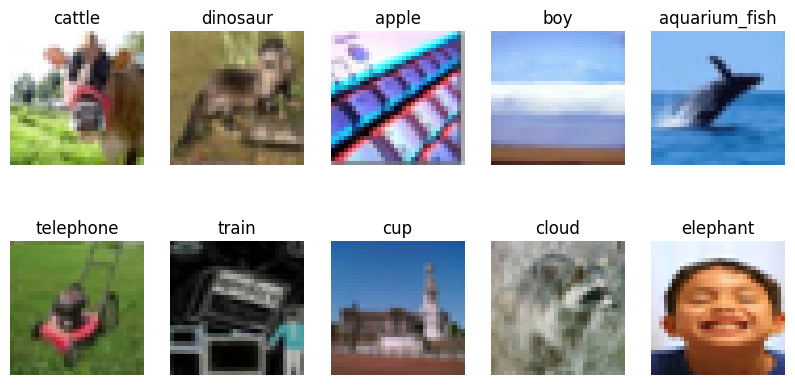

In [ ]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
    'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Größe der Abbildung festlegen
plt.figure(figsize=(10, 5))

# Schleife über die ersten 10 Bilder
for i in range(10):
    # Subplot erstellen (2 Zeilen, 5 Spalten), aktuelles Subplot auswählen
    plt.subplot(2, 5, i + 1)

    # Index für das aktuelle Bild
    image_index = i * 100 # Wählen Sie hier einen geeigneten Wert für die Schrittweite, um verschiedene Bilder zu erhalten

    # Bild anzeigen
    plt.imshow(x_train[image_index])

    # Titel setzen mit Klassenbezeichnung
    plt.title(class_names[int(y_train[i][0])])


    # Achsenbeschriftungen ausschalten
    plt.axis('off')

# Abbildung anzeigen
plt.show()



In [ ]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

###Adding augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(x_train)

In [ ]:
# Convert class vectors to binary class matrices
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#Building Model Architecture

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def modifyNet(input_shape, num_classes=100, num_blocks_list=[2, 2, 2, 2], dropout_rate=0.5):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(128, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adding Dropout layer after the first set of residual blocks
    x = layers.Dropout(dropout_rate)(x)

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 2 if i > 0 and j == 0 else 1
            x = resnet_block(x, 128 * 2**i, stride=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

In [ ]:
input_shape = x_train.shape[1:]
model = modifyNet(input_shape, num_classes)


###Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


###Displaing model summary

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_25 (Conv2D)          (None, 32, 32, 128)          3584      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_25 (Ba  (None, 32, 32, 128)          512       ['conv2d_25[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 32, 32, 128)          0         ['batch_normalization_25

#Training the model

In [ ]:
epochs = 30
batch_size = 64
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs)

Epoch 1/30
782/782 [==============================] - 207s 231ms/step - loss: 3.9712 - accuracy: 0.0912
Epoch 2/30
782/782 [==============================] - 180s 230ms/step - loss: 3.3281 - accuracy: 0.1833
Epoch 3/30
782/782 [==============================] - 180s 230ms/step - loss: 2.8472 - accuracy: 0.2771
Epoch 4/30
782/782 [==============================] - 180s 230ms/step - loss: 2.4755 - accuracy: 0.3534
Epoch 5/30
782/782 [==============================] - 180s 230ms/step - loss: 2.1976 - accuracy: 0.4140
Epoch 6/30
782/782 [==============================] - 180s 231ms/step - loss: 1.9761 - accuracy: 0.4622
Epoch 7/30
782/782 [==============================] - 180s 230ms/step - loss: 1.7959 - accuracy: 0.5044
Epoch 8/30
782/782 [==============================] - 180s 230ms/step - loss: 1.6433 - accuracy: 0.5396
Epoch 9/30
782/782 [==============================] - 180s 230ms/step - loss: 1.5141 - accuracy: 0.5717
Epoch 10/30
782/782 [==============================] - 180s 230m

###Training for 20 more epoches

In [ ]:
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=20)

Epoch 1/20
782/782 [==============================] - 177s 227ms/step - loss: 0.2751 - accuracy: 0.9104
Epoch 2/20
782/782 [==============================] - 177s 226ms/step - loss: 0.2545 - accuracy: 0.9175
Epoch 3/20
782/782 [==============================] - 177s 226ms/step - loss: 0.2389 - accuracy: 0.9230
Epoch 4/20
782/782 [==============================] - 178s 227ms/step - loss: 0.2253 - accuracy: 0.9274
Epoch 5/20
782/782 [==============================] - 177s 227ms/step - loss: 0.2121 - accuracy: 0.9326
Epoch 6/20
782/782 [==============================] - 177s 227ms/step - loss: 0.2078 - accuracy: 0.9325
Epoch 7/20
782/782 [==============================] - 177s 226ms/step - loss: 0.1952 - accuracy: 0.9371
Epoch 8/20
782/782 [==============================] - 177s 226ms/step - loss: 0.1863 - accuracy: 0.9401
Epoch 9/20
782/782 [==============================] - 177s 227ms/step - loss: 0.1784 - accuracy: 0.9424
Epoch 10/20
782/782 [==============================] - 177s 227m

#Visualizing learning curve of model

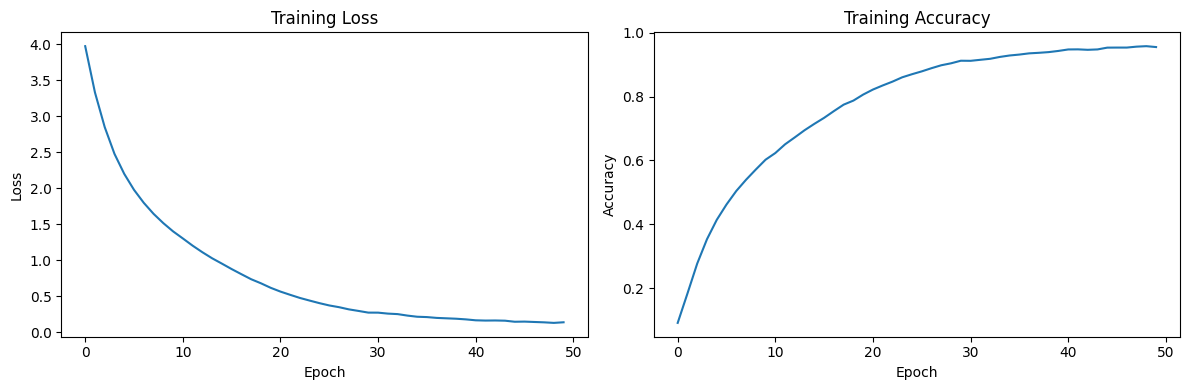

In [ ]:
# Logs from additional training for 20 epochs
history2 = {
    'loss': [0.2709, 0.2576, 0.2506, 0.2301, 0.2141, 0.2093, 0.1979, 0.1922, 0.1865, 0.1773, 0.1645, 0.1609, 0.1621, 0.1592, 0.1445, 0.1465, 0.1413, 0.1363, 0.1287, 0.1372],
    'accuracy': [0.9123, 0.9155, 0.9186, 0.9245, 0.9290, 0.9319, 0.9357, 0.9374, 0.9396, 0.9433, 0.9479, 0.9482, 0.9468, 0.9480, 0.9536, 0.9538, 0.9538, 0.9567, 0.9582, 0.9554]
}

# Concatenate the history data
combined_history = {
    'loss': history.history['loss'] + history2['loss'],
    'accuracy': history.history['accuracy'] + history2['accuracy']
}

# Plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(combined_history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

#Printing Test Accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')

313/313 - 11s - loss: 4.6053 - accuracy: 0.0100 - 11s/epoch - 35ms/step
Test Accuracy: 1.00%


#Saving the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
model.save('/content/gdrive/My Drive/CIFAR_100_NN_Model.h5')
model_json = model.to_json()
with open('my_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save_weights('my_model_weights.h5')

In [ ]:
!ls !ls '/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'

'/content/gdrive/My Drive/CIFAR_100_NN_Model.h5'


#Making Predictions


In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 10s 31ms/step


### Display the first few test images along with their predicted and actual classes

1/1 [==============================] - 0s 29ms/step


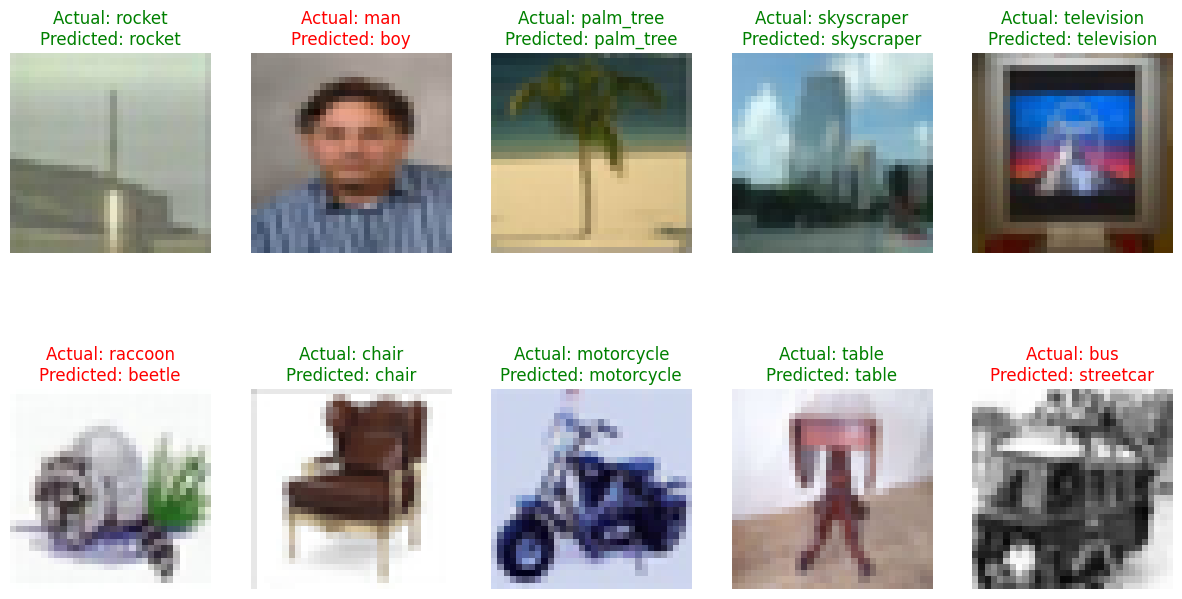

In [ ]:
# Choose 10 random indices
random_indices = random.sample(range(len(x_test)), 10)

# Make predictions on the selected random test data
selected_x_test = x_test[random_indices]
selected_y_test = y_test[random_indices]
selected_predictions = model.predict(selected_x_test)

# Display the randomly selected test images along with their predicted and actual classes
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx])

    actual_class = int(np.argmax(selected_y_test[i]))  # Assuming y_test is one-hot encoded
    predicted_class = int(np.argmax(selected_predictions[i]))

    # Check if the prediction is correct
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.title(f'Actual: {class_names[actual_class]}\nPredicted: {class_names[predicted_class]}', color=text_color)
    plt.axis('off')

plt.show()